<a href="https://colab.research.google.com/github/abhishek-shrm/delhi-temperature-forecasting/blob/master/delhi_temperature_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Delhi Temperature Prediction**
Welcome to the Delhi Temperature Prediction project. It is a forecasting problem where I have to forecast the temperature of Delhi at a specific date. Before doing this, I didn't know anything about time series. I have never worked on time series before. Working on this project was quite challenging, and I still don't know if I am even a little bit right. But I have learned a lot while working on this project. So, let's start by installing the required packages. I am installing meteocalc for performing meteorological calculations.

In [1]:
!pip install meteocalc

  Created wheel for meteocalc: filename=meteocalc-1.1.0-cp36-none-any.whl size=8196 sha256=4daf10fb3c1822e43fe53765035bc9733530ca90c4809239b7812e776efba7c4
  Stored in directory: /root/.cache/pip/wheels/9e/34/13/83d36ecc28837e3c2a5b696542e697538e7c1025382f4ded55
Successfully built meteocalc


In [0]:
# Importing important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime 
import statsmodels.api as sm
import seaborn as sns
from meteocalc import Temp, heat_index
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas import Series        # To work on series 
%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

### **Problem Statement**
To prepare a model which takes date as input and predicts temperature for it.

### **Data Understanding**
I have downloaded the dataset and uploaded it to my GitHub repository so that I can easily access it inside the Google Colab. Now, I am loading the dataset and displaying first 5 rows of it.

In [130]:
# Importing dataset
url='https://raw.githubusercontent.com/abhishek-shrm/delhi-temperature-forecasting/master/Weather_data.csv'
df=pd.read_csv(url)
df.head(5)

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


Let's take a look at different properties of the dataset.

In [131]:
# data type of columns in dataset
df.dtypes

datetime_utc     object
 _conds          object
 _dewptm        float64
 _fog             int64
 _hail            int64
 _heatindexm    float64
 _hum           float64
 _precipm       float64
 _pressurem     float64
 _rain            int64
 _snow            int64
 _tempm         float64
 _thunder         int64
 _tornado         int64
 _vism          float64
 _wdird         float64
 _wdire          object
 _wgustm        float64
 _windchillm    float64
 _wspdm         float64
dtype: object

As we can see, the 'datetime_utc' column is not of datatype 'datetime.' Therefore, I am converting column 'datetime_utc' from object type to DateTime type.

In [0]:
df['datetime_utc']=pd.to_datetime(df['datetime_utc'],format="%Y%m%d-%H:%M")

In [133]:
# Shape of Data
df.shape

(98913, 20)

In [134]:
# Columns of the dataset
df.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')

In [135]:
# Getting Info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98913 entries, 0 to 98912
Data columns (total 20 columns):
datetime_utc    98913 non-null datetime64[ns]
 _conds         98845 non-null object
 _dewptm        98294 non-null float64
 _fog           98913 non-null int64
 _hail          98913 non-null int64
 _heatindexm    29111 non-null float64
 _hum           98160 non-null float64
 _precipm       0 non-null float64
 _pressurem     98682 non-null float64
 _rain          98913 non-null int64
 _snow          98913 non-null int64
 _tempm         98244 non-null float64
 _thunder       98913 non-null int64
 _tornado       98913 non-null int64
 _vism          94497 non-null float64
 _wdird         84533 non-null float64
 _wdire         84533 non-null object
 _wgustm        1063 non-null float64
 _windchillm    573 non-null float64
 _wspdm         96560 non-null float64
dtypes: datetime64[ns](1), float64(11), int64(6), object(2)
memory usage: 15.1+ MB


Let's take a look at the statistical description of the data.

In [136]:
df.describe()

,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wgustm,_windchillm,_wspdm
count,98294.000000,98913.000000,98913.000000,29111.000000,98160.000000,0.0,9.868200e+04,98913.000000,98913.00000,98244.000000,98913.000000,98913.000000,94497.000000,84533.000000,1063.000000,573.000000,96560.000000
mean,15.817130,0.067109,0.000131,35.659606,57.774358,NaN,1.951861e+03,0.026498,0.00001,25.578427,0.009362,0.000020,2.419885,162.550980,37.704516,5.708202,7.685854
std,7.096917,0.250213,0.011464,5.013579,23.754463,NaN,3.217101e+05,0.160612,0.00318,8.464732,0.096303,0.004497,20.970678,120.019889,6.841070,1.205967,11.995965
min,-24.000000,0.000000,0.000000,26.800000,4.000000,NaN,-9.999000e+03,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,25.900000,2.100000,0.000000
25%,10.000000,0.000000,0.000000,31.700000,39.000000,NaN,1.002000e+03,0.000000,0.00000,19.000000,0.000000,0.000000,1.500000,50.000000,33.300000,4.900000,0.000000
50%,15.000000,0.000000,0.000000,35.100000,58.000000,NaN,1.008000e+03,0.000000,0.00000,27.000000,0.000000,0.000000,2.000000,150.000000,37.000000,6.100000,7.400000
75%,22.000000,0.000000,0.000000,39.200000,77.000000,NaN,1.014000e+03,0.000000,0.00000,32.000000,0.000000,0.000000,3.000000,270.000000,40.700000,6.800000,11.100000
max,75.000000,1.000000,1.000000,73.600000,243.000000,NaN,1.010614e+08,1.000000,1.00000,90.000000,1.000000,1.000000,6436.000000,960.000000,92.600000,7.300000,1514.900000


After looking at the above table, I found that there are multiple impossible values present in the dataset, which are mentioned as follows:

*   Temperature of Delhi can never go beyond 50 degree Celsius
*   Value of Relative humidity can't be more than 100%
*   Pressure greater than 1084 bar is the highest pressure ever recorded on earth
*   Visibility can never go beyond 10 miles at least for humans
*   Possible value for wind direction is 0-360 degrees
*   Delhi has never faced winds of more than 115 Km/hr

All these values needs to be removed from the dataset because, in reality, these are just errors in the data collection process.

In [137]:
# Removing rows with impossible values for parameters
df=df[df[' _tempm']<50]
df=df[df[' _hum']<100]
df=df[df[' _pressurem']<1084]
df=df[df[' _vism']<=10]
df=df[df[' _wdird']<=360]
df=df[df[' _wspdm']<=115]
# Shape and description of Data
print('Shape=>',df.shape)
df.describe()

Shape=> (77191, 20)


,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wgustm,_windchillm,_wspdm
count,77191.000000,77191.000000,77191.000000,27288.000000,77191.000000,0.0,77191.000000,77191.000000,77191.000000,77191.000000,77191.000000,77191.000000,77191.000000,77191.000000,1028.000000,305.000000,77191.000000
mean,15.714177,0.037440,0.000143,35.694389,53.858403,NaN,943.734622,0.024135,0.000013,26.725059,0.009340,0.000026,2.528051,169.571012,37.735311,5.753770,8.965056
std,7.158649,0.189838,0.011937,5.042356,22.569169,NaN,830.007469,0.153469,0.003599,8.083864,0.096194,0.005090,1.234708,117.902715,6.871999,1.194558,6.954988
min,-24.000000,0.000000,0.000000,26.800000,4.000000,NaN,-9999.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,25.900000,2.100000,0.000000
25%,10.000000,0.000000,0.000000,31.600000,36.000000,NaN,1001.000000,0.000000,0.000000,21.000000,0.000000,0.000000,2.000000,60.000000,33.300000,5.000000,3.700000
50%,15.000000,0.000000,0.000000,35.200000,54.000000,NaN,1007.000000,0.000000,0.000000,28.000000,0.000000,0.000000,2.200000,180.000000,37.000000,6.100000,7.400000
75%,22.000000,0.000000,0.000000,39.200000,72.000000,NaN,1014.000000,0.000000,0.000000,33.000000,0.000000,0.000000,3.000000,270.000000,40.700000,6.800000,13.000000
max,35.000000,1.000000,1.000000,73.600000,99.000000,NaN,1083.000000,1.000000,1.000000,47.000000,1.000000,1.000000,10.000000,360.000000,92.600000,7.300000,114.800000


Let's check if there is any null value present in the dataset.

In [138]:
# No. of null values in each column
df.isnull().sum()

datetime_utc        0
 _conds            27
 _dewptm            0
 _fog               0
 _hail              0
 _heatindexm    49903
 _hum               0
 _precipm       77191
 _pressurem         0
 _rain              0
 _snow              0
 _tempm             0
 _thunder           0
 _tornado           0
 _vism              0
 _wdird             0
 _wdire             0
 _wgustm        76163
 _windchillm    76886
 _wspdm             0
dtype: int64

Columns such as '_precipm', '_wgustm' and '_windchillm' are completely empty columns. Also, column '_conds' contains a lot of categorical values; encoding them only will cause an increase in the number of features that will require a more complex model. Therefore, I am dropping all these columns.

In [139]:
# Removing columns _precipm, _wgustm, _windchillm due to empty column, _wdire because of already existing data and _conds because it will increase complexity
df.drop(columns=[' _precipm',' _wgustm',' _windchillm', ' _wdire', ' _conds'],axis=1,inplace=True)
df.isnull().sum()

datetime_utc        0
 _dewptm            0
 _fog               0
 _hail              0
 _heatindexm    49903
 _hum               0
 _pressurem         0
 _rain              0
 _snow              0
 _tempm             0
 _thunder           0
 _tornado           0
 _vism              0
 _wdird             0
 _wspdm             0
dtype: int64

Now, the only column which has null values is the '_heatindexm' column. I found on the internet that there is a direct relationship between Temperature in F and Humidity. Therefore, I am using the meteocalc package, which helps in calculating the Heat index from temperature and Humidity.

In [140]:
df[' _heatindexm']=df.apply(lambda row: float(heat_index(temperature=Temp(row[' _tempm'],'c').f,humidity=row[' _hum'])) if pd.isnull(row[' _heatindexm']) else row[' _heatindexm'], axis=1)
df.isnull().sum()

datetime_utc    0
 _dewptm        0
 _fog           0
 _hail          0
 _heatindexm    0
 _hum           0
 _pressurem     0
 _rain          0
 _snow          0
 _tempm         0
 _thunder       0
 _tornado       0
 _vism          0
 _wdird         0
 _wspdm         0
dtype: int64

Now, there are no null values present in our dataset. Let's move onto the next phase, which is Feature Engineering.

### **Feature Engineering**
It can be seen that the data also contains a cyclic feature, which is the Wind direction in degree. For model 0 and 360 degrees, both different, but in reality, both are the same. Therefore, I am creating two new columns with the Sin and Cos values of the wind direction.

In [141]:
# Converting cycling features like _wdird to sin and cos
df['wdird_sin']=np.sin(df[' _wdird']*(2.*np.pi/360))
df['wdird_cos']=np.cos(df[' _wdird']*(2.*np.pi/360))
df.drop(columns=[' _wdird'],inplace=True)
df.head()

,datetime_utc,_dewptm,_fog,_hail,_heatindexm,_hum,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wspdm,wdird_sin,wdird_cos
0,1996-11-01 11:00:00,9.0,0,0,83.396678,27.0,1010.0,0,0,30.0,0,0,5.0,7.4,-0.984808,0.173648
4,1996-11-01 16:00:00,11.0,0,0,72.649000,47.0,1011.0,0,0,23.0,0,0,1.2,0.0,0.000000,1.000000
6,1996-11-01 18:00:00,13.0,0,0,69.300000,60.0,1010.0,0,0,21.0,0,0,0.8,0.0,0.000000,1.000000
14,1996-11-02 02:00:00,10.0,0,0,66.944000,52.0,1011.0,0,0,20.0,0,0,2.0,9.3,-0.342020,-0.939693
15,1996-11-02 03:00:00,10.0,0,0,70.622000,46.0,1012.0,0,0,22.0,0,0,3.5,9.3,-0.866025,-0.500000


Since the problem statement requires the datewise temperature of Delhi, therefore I am downsampling the data to dates. Here, I am combining data for each day and taking its mean. I am also checking for null values, if any.

In [142]:
df_daily=df.resample('D',on='datetime_utc').mean()
df_daily.isnull().sum()

 _dewptm        263
 _fog           263
 _hail          263
 _heatindexm    263
 _hum           263
 _pressurem     263
 _rain          263
 _snow          263
 _tempm         263
 _thunder       263
 _tornado       263
 _vism          263
 _wspdm         263
wdird_sin       263
wdird_cos       263
dtype: int64

Downsampling has created some null values in the dataset. It is time to remove them.

In [143]:
df_daily.dropna(inplace=True)
df_daily.isnull().sum()

 _dewptm        0
 _fog           0
 _hail          0
 _heatindexm    0
 _hum           0
 _pressurem     0
 _rain          0
 _snow          0
 _tempm         0
 _thunder       0
 _tornado       0
 _vism          0
 _wspdm         0
wdird_sin       0
wdird_cos       0
dtype: int64

Since I have used, mean for downsampling the dataset, therefore, It has converted categorical values into floating-point numbers. It is time to make our values categorical again.

In [0]:
# Binning values of categorical features
bins=np.linspace(0,1,3)
group_names=[0,1]
df_daily[' _fog']=pd.cut(df_daily[' _fog'],bins,labels=group_names,include_lowest=True).astype(int)
df_daily[' _hail']=pd.cut(df_daily[' _hail'],bins,labels=group_names,include_lowest=True).astype(int)
df_daily[' _rain']=pd.cut(df_daily[' _rain'],bins,labels=group_names,include_lowest=True).astype(int)
df_daily[' _snow']=pd.cut(df_daily[' _snow'],bins,labels=group_names,include_lowest=True).astype(int)
df_daily[' _thunder']=pd.cut(df_daily[' _thunder'],bins,labels=group_names,include_lowest=True).astype(int)
df_daily[' _tornado']=pd.cut(df_daily[' _tornado'],bins,labels=group_names,include_lowest=True).astype(int)

In [145]:
print(df_daily[' _snow'].value_counts(),df_daily[' _hail'].value_counts(),df_daily[' _tornado'].value_counts())

0    7072
Name:  _snow, dtype: int64 0    7072
Name:  _hail, dtype: int64 0    7072
Name:  _tornado, dtype: int64


But, as you can see after this process, three columns '_snow', '_hail,' and '_tornado' have become empty. It is time to remove them. I also found later on that all the categorical features, even those created by me, contains a high number of zeroes which goes to infinity after the logarithmic transformation. Therefore, they, too, need to be removed.

In [146]:
df_daily.drop(columns=[' _snow',' _hail',' _tornado',' _fog',' _rain',' _thunder','wdird_sin','wdird_cos'],inplace=True)
print("Shape=>",df_daily.shape)
df_daily.head()

Shape=> (7072, 7)


,_dewptm,_heatindexm,_hum,_pressurem,_tempm,_vism,_wspdm
datetime_utc,,,,,,,
1996-11-01,11.000000,75.115226,44.666667,1010.333333,24.666667,2.333333,2.466667
1996-11-02,10.333333,72.767044,47.190476,1009.809524,23.380952,3.476190,8.028571
1996-11-03,12.136364,68.940548,54.681818,1010.500000,22.272727,2.286364,4.804545
1996-11-04,10.133333,68.857038,46.600000,1011.333333,23.133333,2.326667,2.226667
1996-11-05,8.200000,80.059030,29.400000,1011.800000,27.800000,3.900000,10.020000


It is now time to visualize our data on a daily, monthly, and yearly level. It helps in getting an idea about the trends and seasonality present in the dataset.

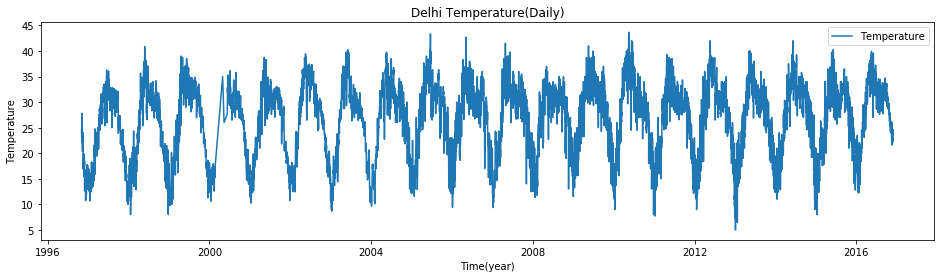

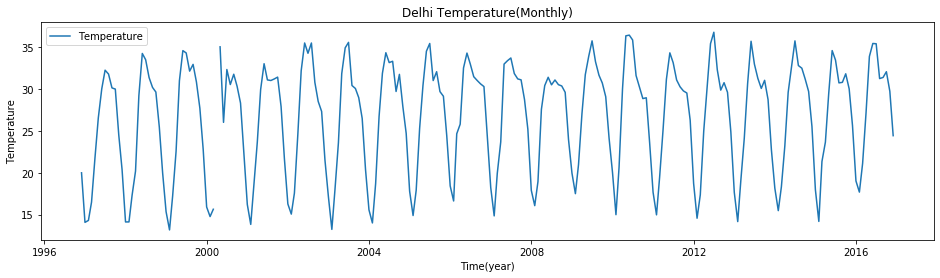

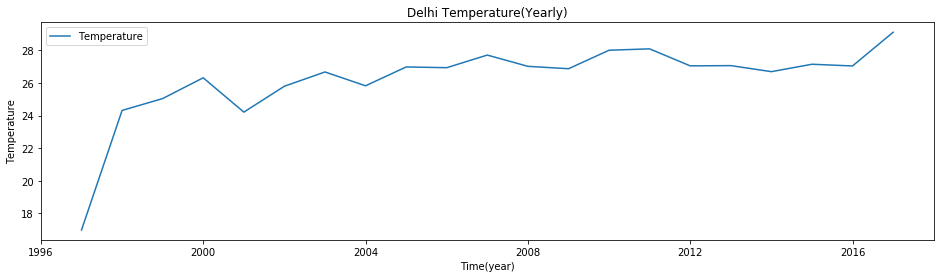

In [147]:
# Visualizing temperature on the daily, monthly, and yearly basis
plt.figure(figsize=(16,4)) 
plt.plot(df_daily[' _tempm'], label='Temperature') 
plt.title('Delhi Temperature(Daily)') 
plt.xlabel("Time(year)") 
plt.ylabel("Temperature") 
plt.legend(loc='best')
plt.figure(figsize=(16,4)) 
plt.plot(df_daily.resample('M')[' _tempm'].mean(), label='Temperature') 
plt.title('Delhi Temperature(Monthly)') 
plt.xlabel("Time(year)") 
plt.ylabel("Temperature") 
plt.legend(loc='best')
plt.figure(figsize=(16,4)) 
plt.plot(df_daily.resample('Y')[' _tempm'].mean(), label='Temperature') 
plt.title('Delhi Temperature(Yearly)') 
plt.xlabel("Time(year)") 
plt.ylabel("Temperature") 
plt.legend(loc='best')

It can be seen that our data has both seasonality and trend. It needs to be removed. I have to make the data stationary. Stationary data has a constant mean and covariance. To remove the seasonality and trend, I will perform some transformations later. To make plotting graphs easier, I have created a function tsplot(), which plots the data over the time axis.

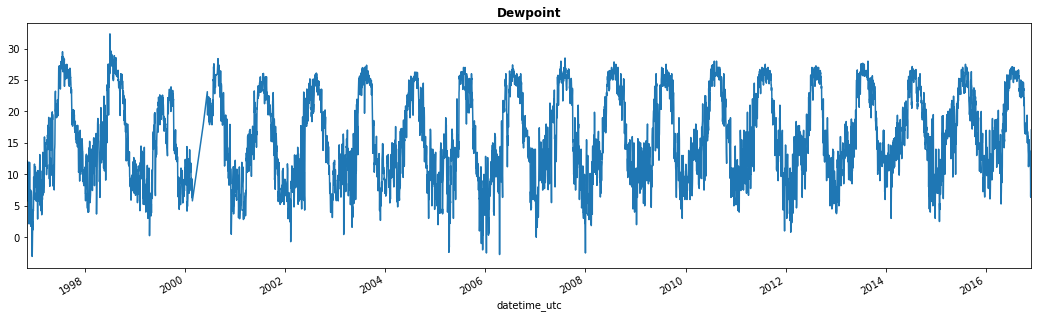

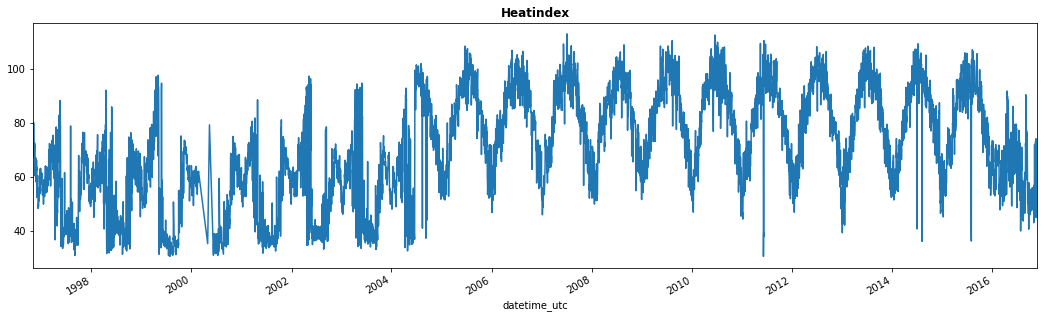

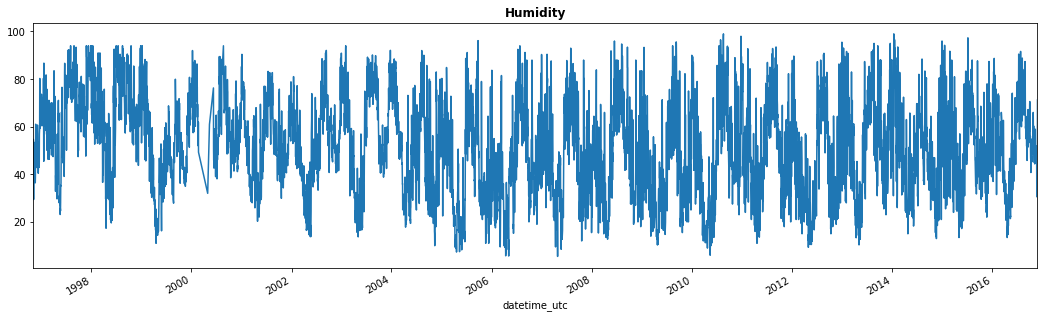

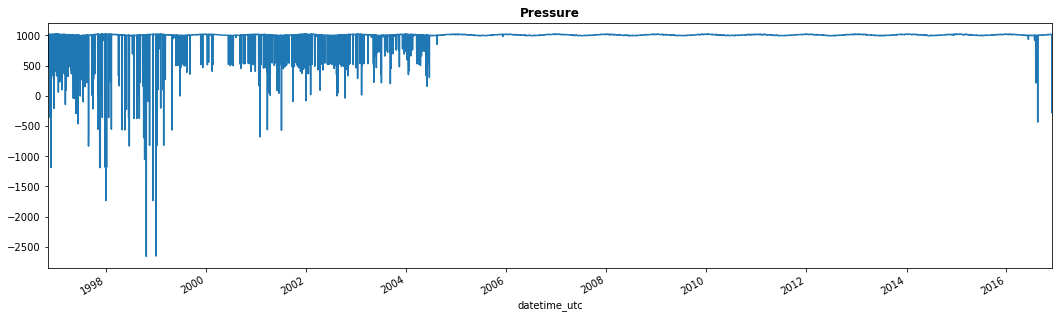

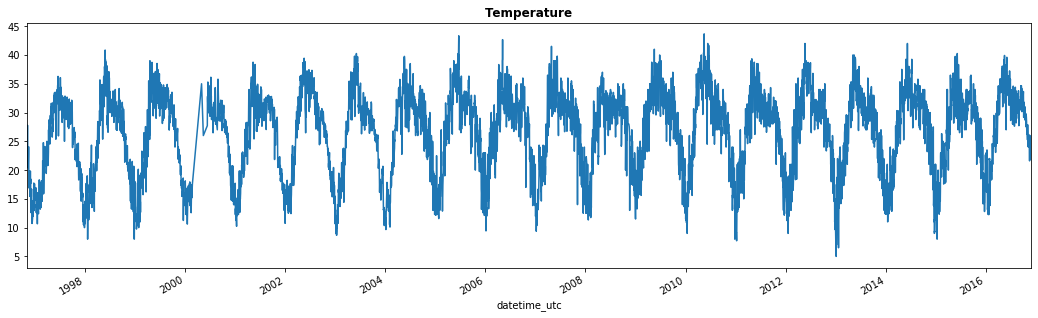

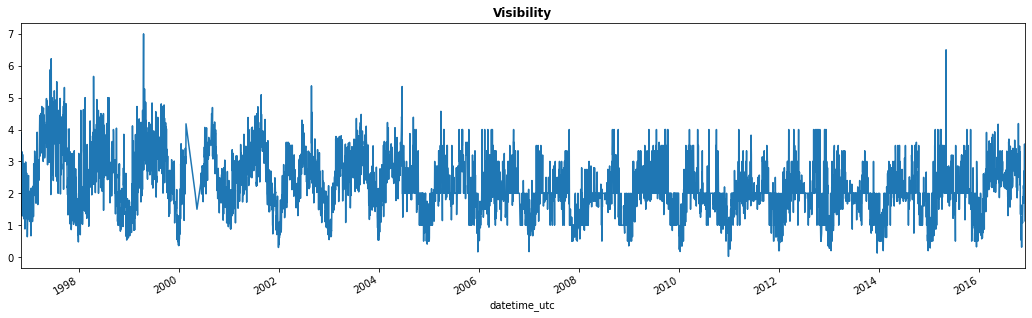

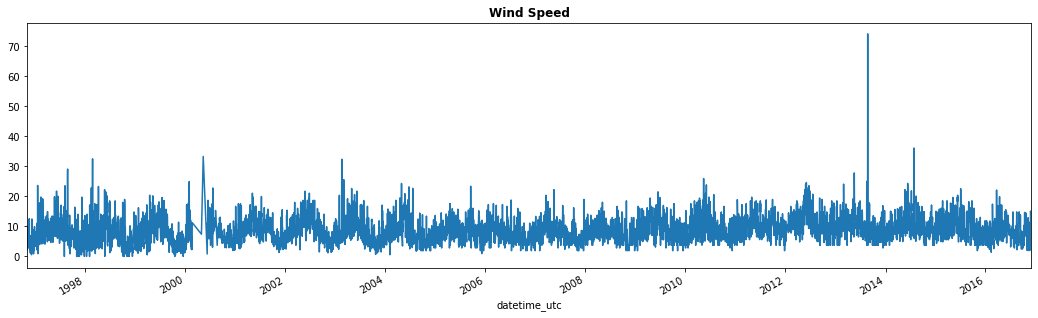

In [148]:
def tsplot(y, title, lags=None, figsize=(18, 5)):
    plt.figure(figsize=figsize)
    ts_ax = plt.subplot(111)
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()
    return ts_ax

labels=['Dewpoint','Heatindex','Humidity','Pressure','Temperature','Visibility','Wind Speed']
for i in zip(df_daily.columns,labels):
  tsplot(df_daily[i[0]],i[1])

Now, I am using logarithms to standardize my dataset.

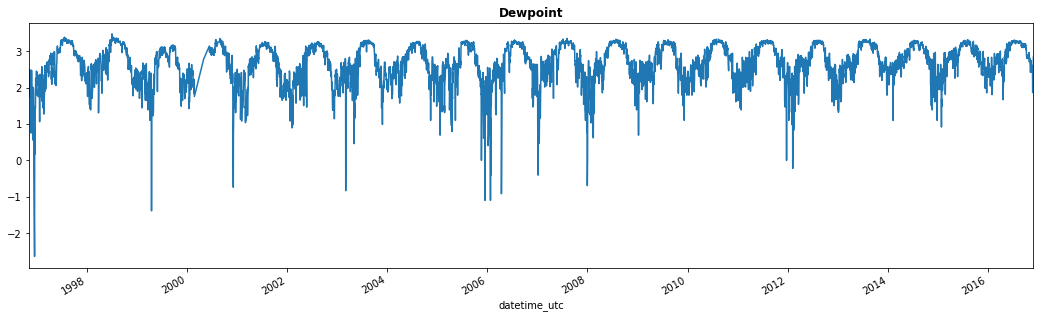

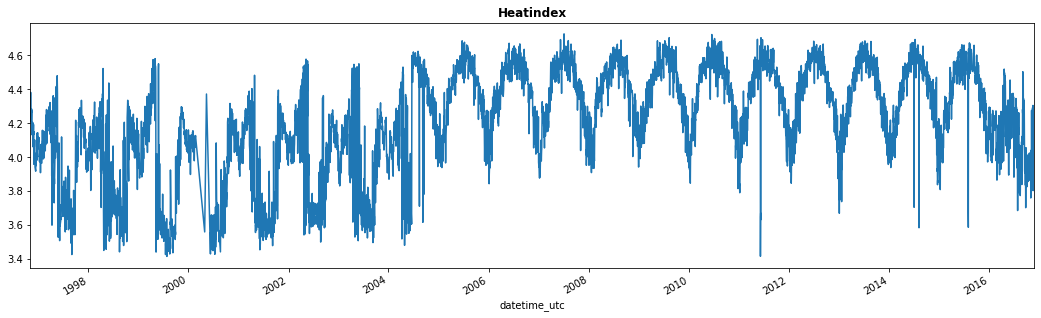

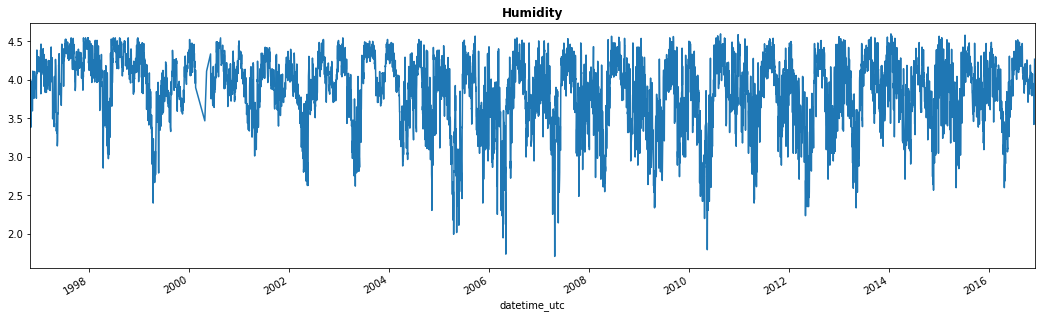

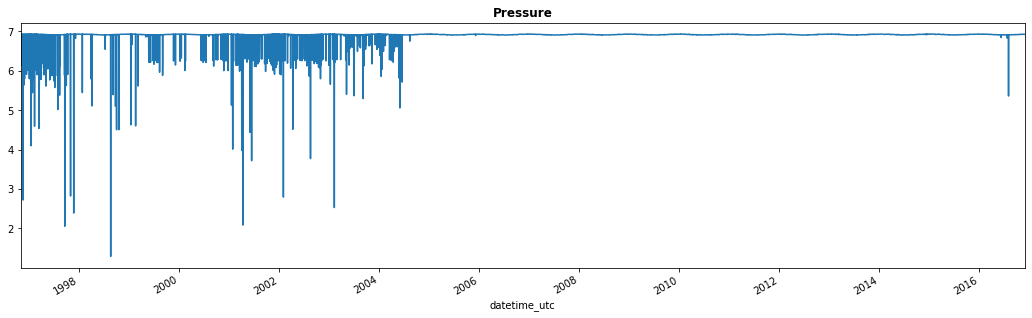

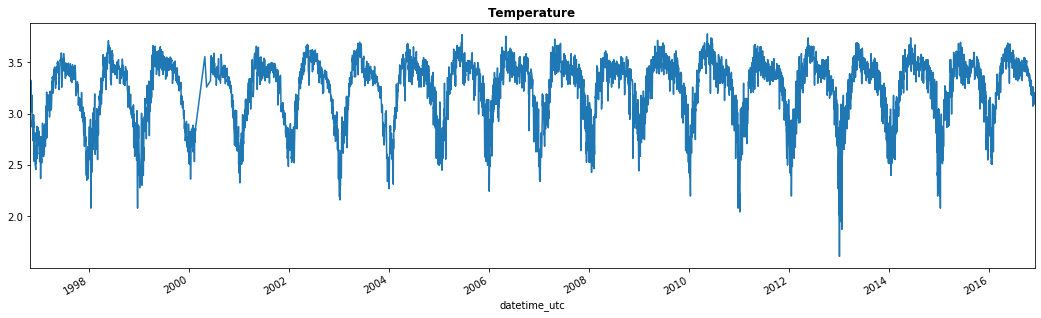

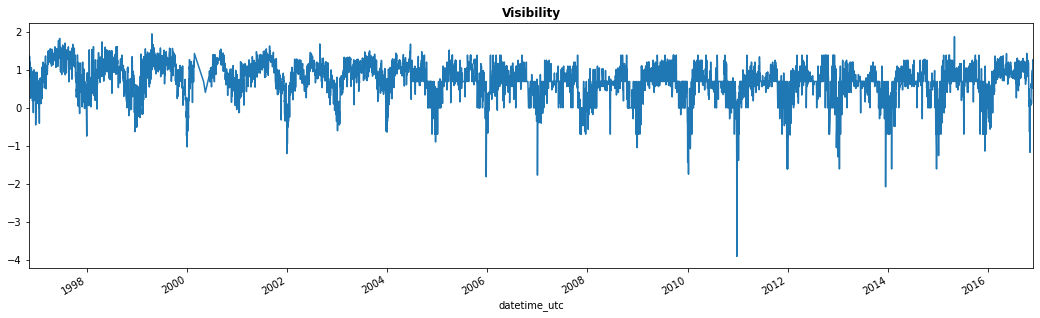

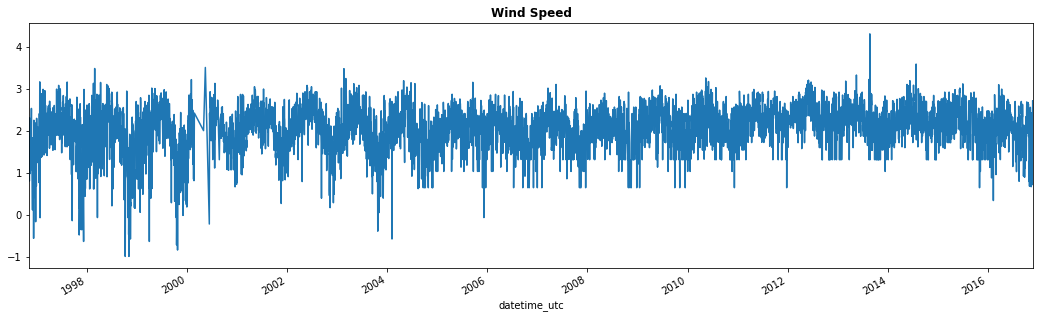

In [149]:
# Making data stationary
 #Scaling down data using log
df_daily_logScaled=df_daily.copy()
df_daily_logScaled[' _dewptm']=np.log(df_daily[' _dewptm'])
df_daily_logScaled[' _heatindexm']=np.log(df_daily[' _heatindexm'])
df_daily_logScaled[' _hum']=np.log(df_daily[' _hum'])
df_daily_logScaled[' _pressurem']=np.log(df_daily[' _pressurem'])
df_daily_logScaled[' _tempm']=np.log(df_daily[' _tempm'])
df_daily_logScaled[' _vism']=np.log(df_daily[' _vism'])
df_daily_logScaled[' _wspdm']=np.log(df_daily[' _wspdm'])
df_daily_logScaled.replace([np.inf,-np.inf],np.nan,inplace=True)
df_daily_logScaled.dropna(inplace=True)
for i in zip(df_daily_logScaled.columns,labels):
  tsplot(df_daily_logScaled[i[0]],i[1])

It is visible that data is standardized. Now, I am taking forward difference of the data. I am taking the difference of (t) and (t+1) samples. It helps in removing the seasonality from the data.

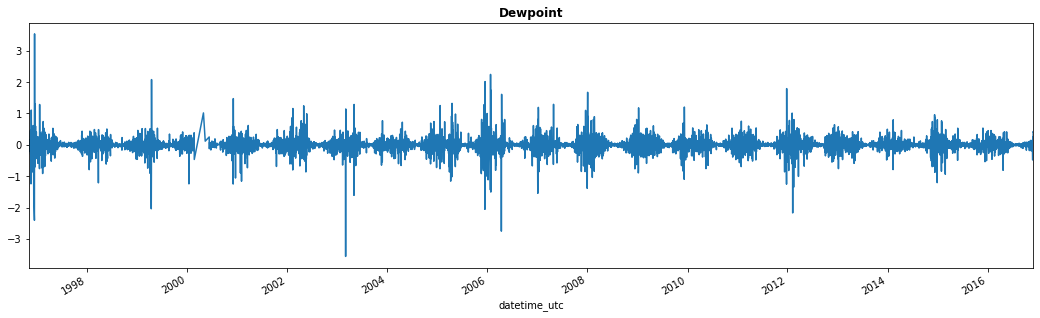

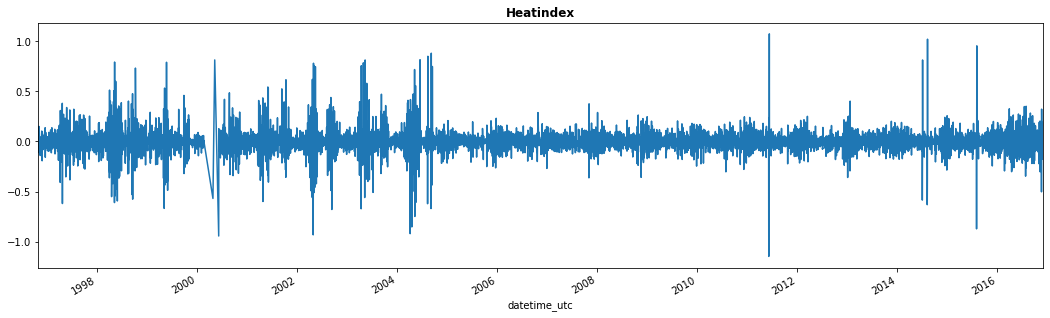

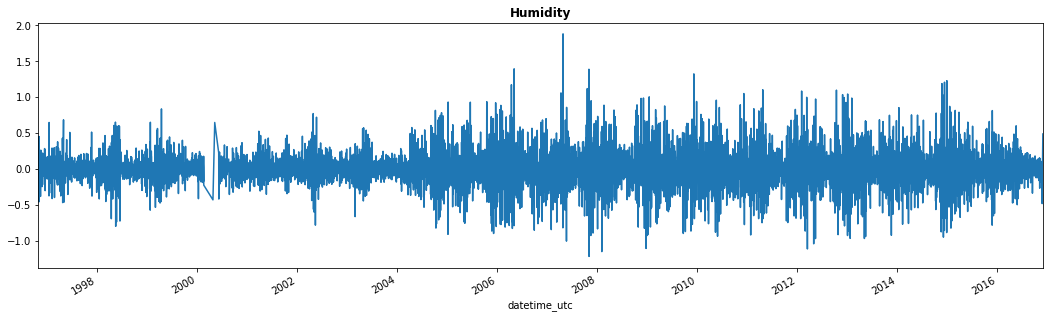

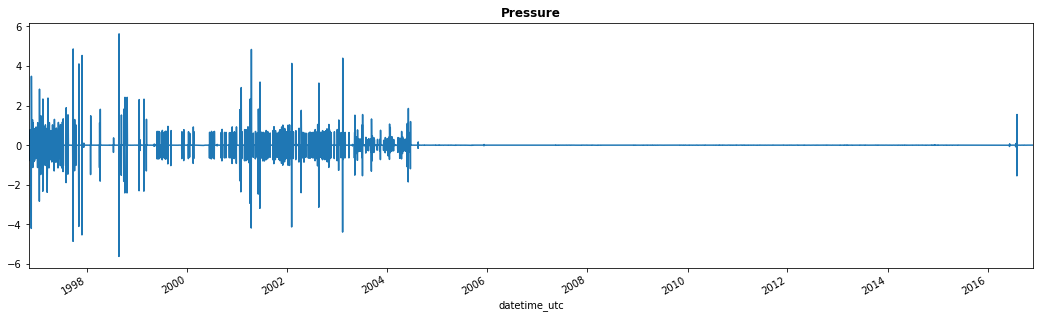

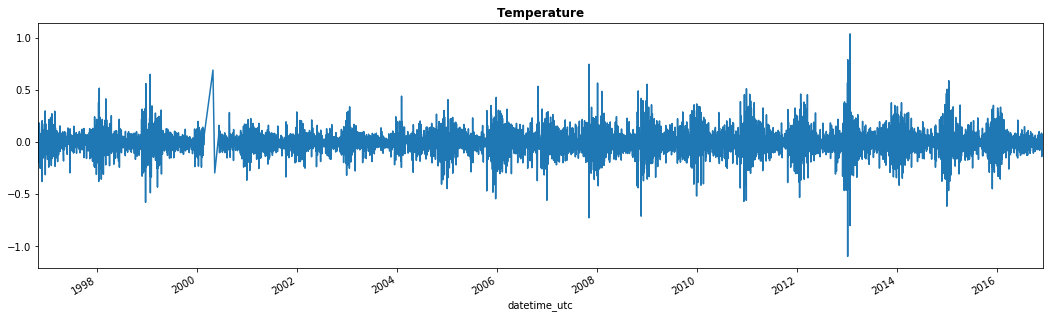

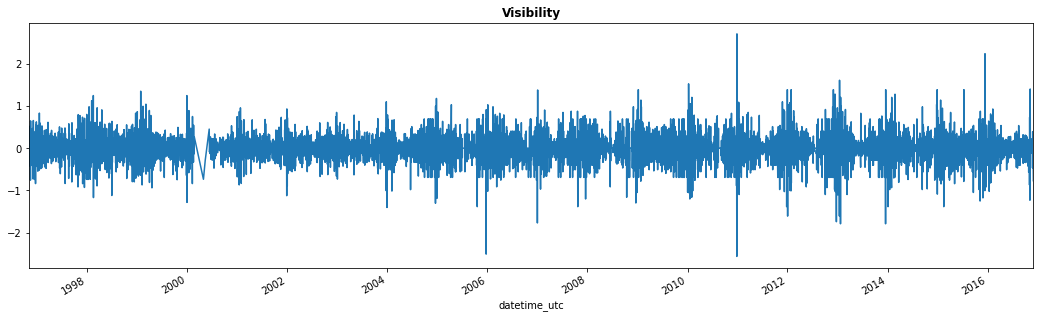

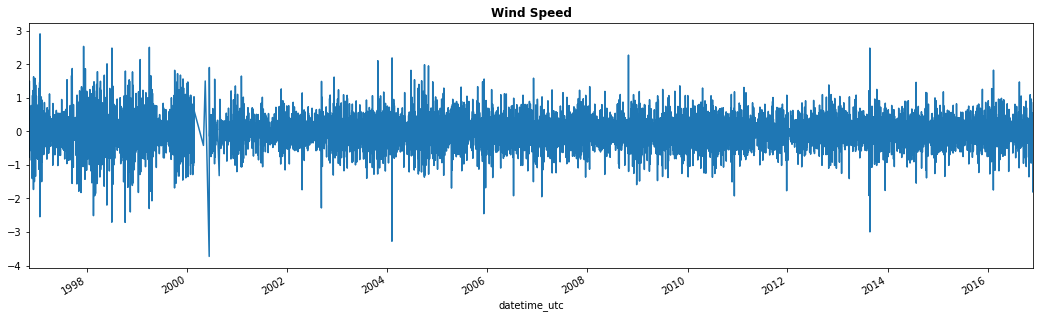

In [150]:
df_daily_logScaled_Diff=df_daily_logScaled-df_daily_logScaled.shift(1)
df_daily_logScaled_Diff.dropna(inplace=True)
for i in zip(df_daily_logScaled_Diff.columns,labels):
  tsplot(df_daily_logScaled_Diff[i[0]],i[1])

Now, I am performing the Johansen Cointegration test to see if my data is now stationary or not. If the value is greater than zero, then the data is stationary. In the case of a single variate forecasting adfuller test is used, whereas in the case of multivariate forecasting Johansen Cointegration test is used.

In [151]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp=df_daily_logScaled_Diff
coint_johansen(johan_test_temp,-1,1).eig

array([0.59301671, 0.56620152, 0.52529973, 0.52039533, 0.48175011,
       0.46342116, 0.41212172])

Data is stationary now, which can be seen from plotted graphs, but the test does not have high confidence scores. I have created a function tsplotall(), which plots the line graph, Auto Correlation, and Partial Auto Correlation graphs, which helps in our further analysis.

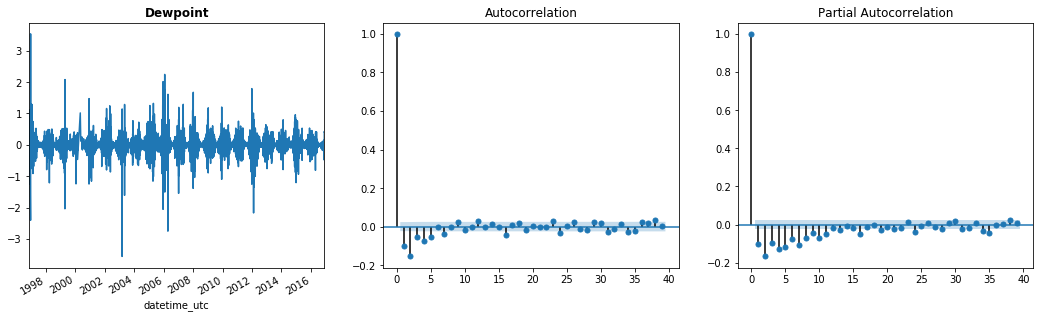

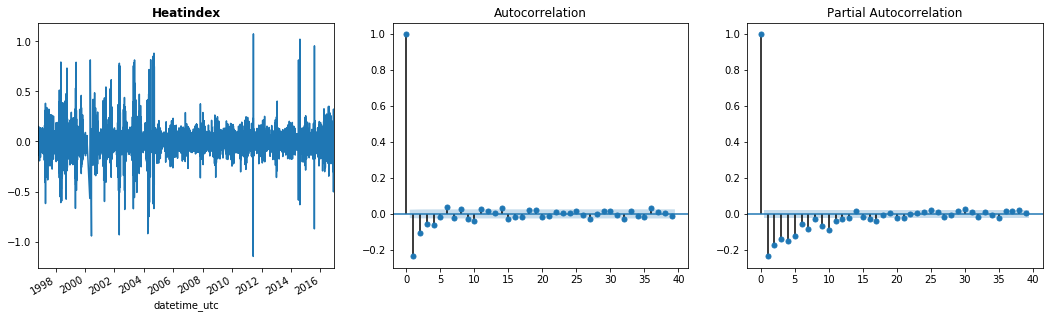

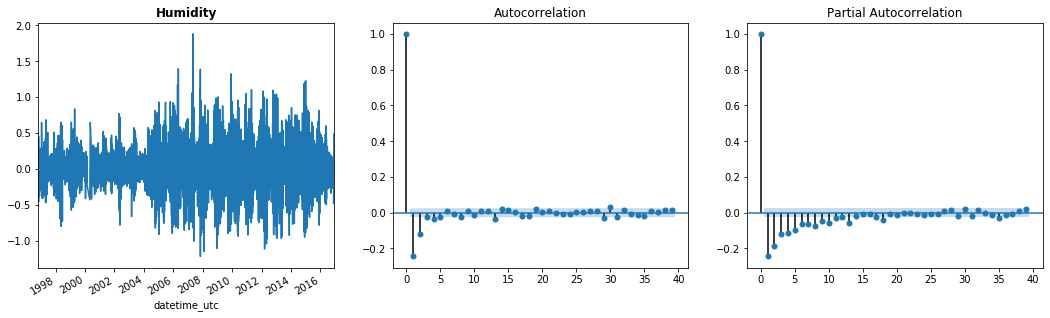

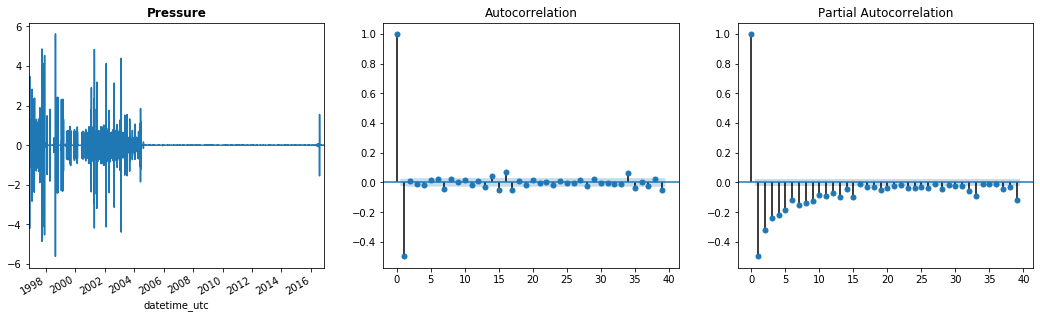

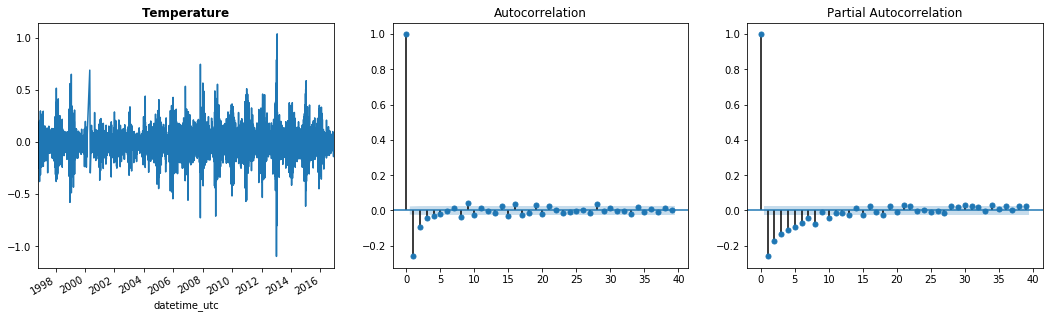

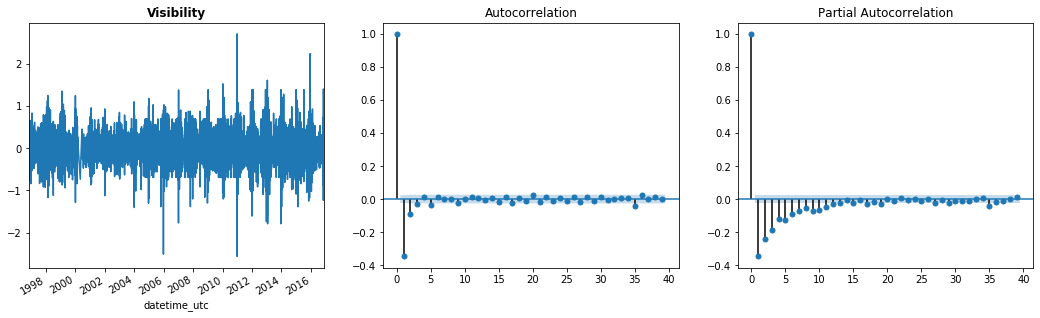

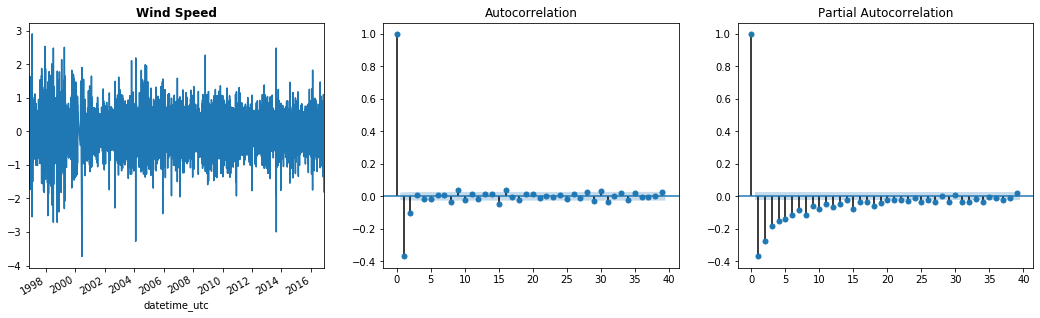

In [152]:
def tsplotall(y, title, lags=None, figsize=(18, 5)):
    plt.figure(figsize=figsize)
    ts_ax = plt.subplot(131)
    acf_ax = plt.subplot(132)
    pacf_ax = plt.subplot(133)
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    sm.tsa.graphics.plot_acf(y.dropna(), lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y.dropna(), lags=lags, ax=pacf_ax)
    plt.show()
    return ts_ax,acf_ax,pacf_ax

for i in zip(df_daily_logScaled_Diff.columns,labels):
  tsplotall(df_daily_logScaled_Diff[i[0]],i[1])

Now, I am splitting the dataset into train and test set. I will be using the last 3 months of data for testing and remaining data for the training purposes.

In [153]:
# Splitting data into train and test
train=df_daily_logScaled_Diff.drop(columns=[' _dewptm'],axis=1).ix['1996-11-01':'2016-06-30']
test=df_daily_logScaled_Diff.drop(columns=[' _dewptm'],axis=1).ix['2016-07-01':'2016-11-30']
print(train.shape,test.shape)

(6823, 6) (151, 6)


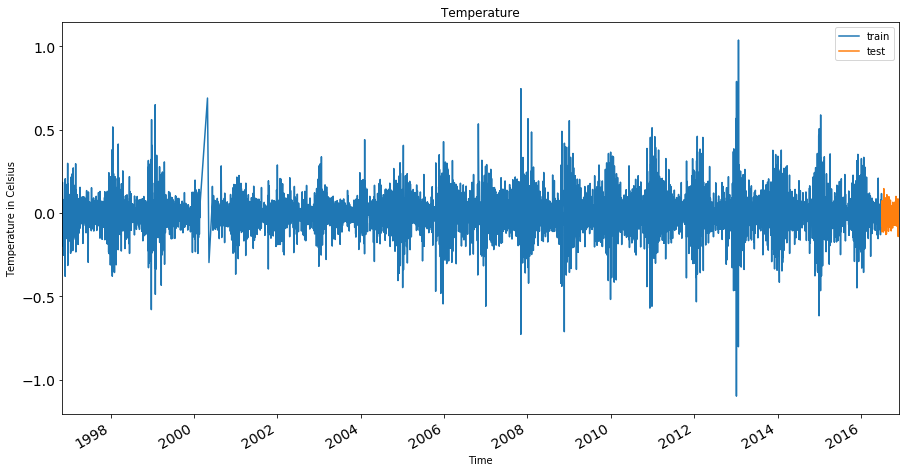

In [154]:
# Visualizing train and test split
train[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='train')
test[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='test')
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.legend(loc='best')
plt.show()

### Vector Auto Regression (VAR)
VAR is a model used for multivariate forecasting. It also captures interdependencies between multiple time series.

In [155]:
# Fitting the model
model = VAR(endog=train)
model_fit = model.fit()
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 29, Jan, 2020
Time:                     23:43:18
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -18.9746
Nobs:                     6822.00    HQIC:                  -19.0022
Log likelihood:           6827.83    FPE:                5.51024e-09
AIC:                     -19.0167    Det(Omega_mle):     5.47643e-09
--------------------------------------------------------------------
Results for equation  _heatindexm
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.000014         0.001348            0.010           0.992
L1. _heatindexm        -0.240407         0.013222          -18.182           0.000
L1. _hum               -0.015554         0.00

In [156]:
# Taking the predictions for the test set
prediction = model_fit.forecast(model_fit.y, steps=len(test.dropna()))
pred = pd.DataFrame(index=range(0,len(prediction)),columns=test.columns)
for j in range(0,6):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]
pred.index=test.dropna().index       
pred       

,_heatindexm,_hum,_pressurem,_tempm,_vism,_wspdm
datetime_utc,,,,,,
2016-07-01,-0.00428354,-0.00376187,0.00231764,0.0033726,0.0156575,0.0803032
2016-07-02,-5.26061e-07,0.0045399,-0.00119078,-0.00268201,-0.00248833,-0.029296
2016-07-03,0.000353403,-0.00262131,0.000597407,0.00145325,2.86257e-05,0.0105869
2016-07-04,-0.000182034,0.00127416,-0.000309202,-0.000537277,0.000149638,-0.00369542
2016-07-05,9.11841e-05,-0.000492162,0.000158515,0.000303308,-0.000175806,0.00135269
...,...,...,...,...,...,...
2016-11-25,9.91676e-06,3.04569e-05,-1.56214e-06,6.33588e-05,-4.36947e-05,4.29353e-05
2016-11-26,9.91676e-06,3.04569e-05,-1.56214e-06,6.33588e-05,-4.36947e-05,4.29353e-05
2016-11-27,9.91676e-06,3.04569e-05,-1.56214e-06,6.33588e-05,-4.36947e-05,4.29353e-05


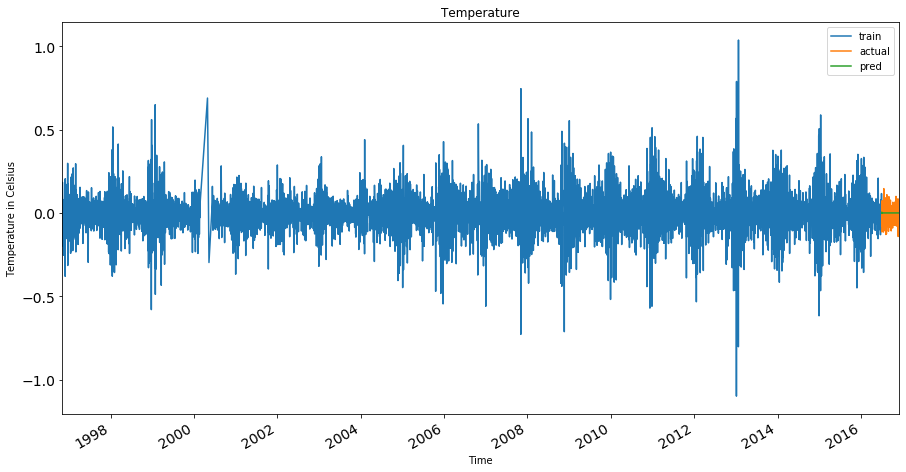

In [158]:
# Plotting the graph of predicted value without transformations
train[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='train')
test[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='actual')
pred[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='pred')
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.legend(loc='best')
plt.show()

In [50]:
# Last observation of training set for temperature
df_daily[' _tempm'].ix['2016-06-30']

35.785714285714285

Taking forward sum of data to retrieve original data. I am doing this only for temperature beacause that's what we are interested in.

In [159]:
pred[' _tempm'][0]=35.785714285714285+pred[' _tempm'][0]
pred[' _tempm']=pred[' _tempm'].cumsum()
pred

,_heatindexm,_hum,_pressurem,_tempm,_vism,_wspdm
datetime_utc,,,,,,
2016-07-01,-0.00428354,-0.00376187,0.00231764,35.7891,0.0156575,0.0803032
2016-07-02,-5.26061e-07,0.0045399,-0.00119078,35.7864,-0.00248833,-0.029296
2016-07-03,0.000353403,-0.00262131,0.000597407,35.7879,2.86257e-05,0.0105869
2016-07-04,-0.000182034,0.00127416,-0.000309202,35.7873,0.000149638,-0.00369542
2016-07-05,9.11841e-05,-0.000492162,0.000158515,35.7876,-0.000175806,0.00135269
...,...,...,...,...,...,...
2016-11-25,9.91676e-06,3.04569e-05,-1.56214e-06,35.7966,-4.36947e-05,4.29353e-05
2016-11-26,9.91676e-06,3.04569e-05,-1.56214e-06,35.7966,-4.36947e-05,4.29353e-05
2016-11-27,9.91676e-06,3.04569e-05,-1.56214e-06,35.7967,-4.36947e-05,4.29353e-05


In [163]:
#checking RMSE
    print('rmse value  is : ', sqrt(mean_squared_error(pred[' _tempm'],df_daily.ix['2016-06-30':'2016-11-27'][' _tempm'].dropna())))

rmse value  is :  6.671327018216823


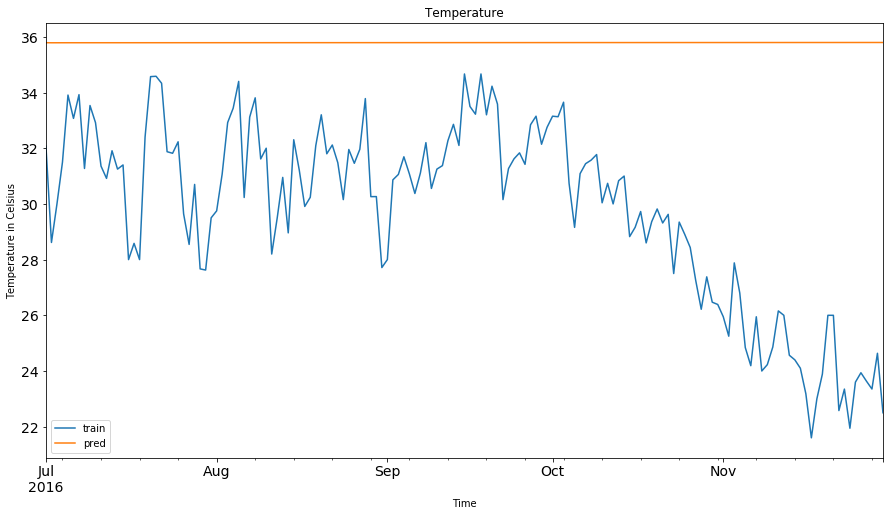

In [165]:
# Visualizing predictions and test set
df_daily.ix['2016-07-01':'2016-11-30'][' _tempm'].plot(figsize=(15,6), title= 'Temperature', fontsize=14, label='train')
pred[' _tempm'].plot(figsize=(15,8), title= 'Temperature', fontsize=14, label='pred')
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.legend(loc='best')
plt.show()

Now, I am forecasting temperature for further few steps.

In [171]:
date1 = '2015-12-01'
date2 = '2016-7-30'
mydates = pd.date_range(date1, date2).tolist()
prediction_steps = model_fit.forecast(model_fit.y, steps=len(mydates))
pred_steps = pd.DataFrame(index=range(0,len(prediction_steps)),columns=test.columns)
for j in range(0,6):
    for i in range(0, len(mydates)):
       pred_steps.iloc[i][j] = prediction_steps[i][j]
pred_steps.index=mydates
pred_steps[' _tempm'][0]=27+pred_steps[' _tempm'][0]
pred_steps[' _tempm']=pred_steps[' _tempm'].cumsum()
pred_steps[' _tempm']=pred_steps[' _tempm'].astype(float)
pred_steps

,_heatindexm,_hum,_pressurem,_tempm,_vism,_wspdm
2015-12-01,-0.00428354,-0.00376187,0.00231764,27.003373,0.0156575,0.0803032
2015-12-02,-5.26061e-07,0.0045399,-0.00119078,27.000691,-0.00248833,-0.029296
2015-12-03,0.000353403,-0.00262131,0.000597407,27.002144,2.86257e-05,0.0105869
2015-12-04,-0.000182034,0.00127416,-0.000309202,27.001607,0.000149638,-0.00369542
2015-12-05,9.11841e-05,-0.000492162,0.000158515,27.001910,-0.000175806,0.00135269
...,...,...,...,...,...,...
2016-07-26,9.91676e-06,3.04569e-05,-1.56214e-06,27.016669,-4.36947e-05,4.29353e-05
2016-07-27,9.91676e-06,3.04569e-05,-1.56214e-06,27.016733,-4.36947e-05,4.29353e-05
2016-07-28,9.91676e-06,3.04569e-05,-1.56214e-06,27.016796,-4.36947e-05,4.29353e-05
2016-07-29,9.91676e-06,3.04569e-05,-1.56214e-06,27.016859,-4.36947e-05,4.29353e-05


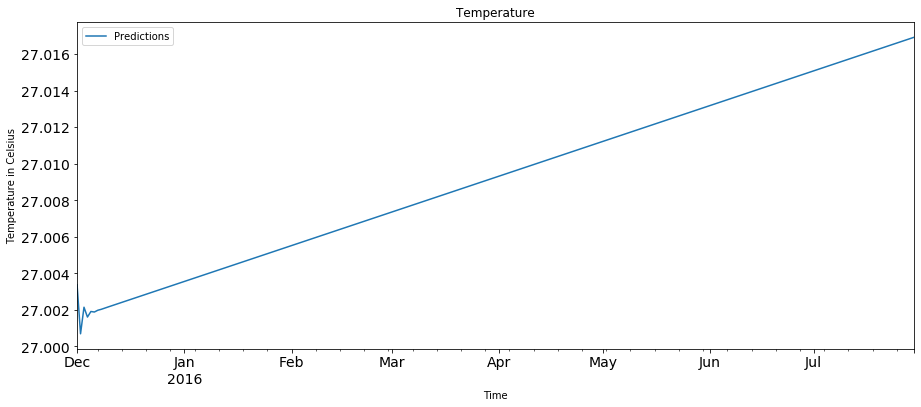

In [172]:
# Visualizing predictions
pred_steps[' _tempm'].plot(figsize=(15,6), title= 'Temperature', fontsize=14, label='Predictions')
plt.xlabel("Time")
plt.ylabel("Temperature in Celsius")
plt.legend(loc='best')
plt.show()

### **Final**
Now it is time to train the VAR model on the whole dataset and saving it.

In [0]:
# Training the model on whole dataset
final_model=VAR(endog=df_daily_logScaled_Diff.drop(columns=[' _dewptm'],axis=1).dropna())
final_fit = model.fit()

In [177]:
joblib.dump(final_fit,'model.pkl')

['model.pkl']

I understand that my steps are not right in multiple stages, and there is so much room for further improvements. But before getting this project, I knew nothing about the time series. I tried my best to learn all the stuff I could and complete this project in the best way out there. I learned a lot during this task that now I want to explore more about the time series. Please provide the feedback so that I can improve myself and this project further.